### First 2 rows are to import the necessary libraries and to ignore the warnings

In [1]:
import io
import PyPDF2
import pandas as pd
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import datetime as dt

In [2]:
warnings.filterwarnings("ignore")

### With this loop we get the PDFs into a dataframe (we can also save them into a csv)

In [3]:
path = 'dataset/train6/'
dfpdf = pd.DataFrame()
for g,h in enumerate(os.listdir(path)):
    file = open(path+h, 'rb')
    fileReader = PyPDF2.PdfFileReader(file)
    if fileReader.numPages != 1:
        print("este pdf es distinto")
        continue
    pageObj = fileReader.getPage(0)
    texto = pageObj.extractText()
    texto = texto.replace(" ","")
    texto = texto.split("\n")
    diccio = dict()
    for i,j in enumerate(texto):
        if j:
            if j.endswith(":"):
                diccio[texto[i][:-1]]=texto[i+1]
            elif (not j.isupper()) and (j not in diccio.values()):
                if texto[i-1] not in diccio.values():
                    diccio[texto[i-1]]=texto[i]
    dfpdf = dfpdf.append(pd.Series(diccio).to_frame().T)

In [4]:
dfpdf.to_csv("pdfs.csv")

In [5]:
dfcsv = pd.read_csv("toadriyjc.csv",";")

In [6]:
dfjsons = pd.read_csv("jsons")

### In the following lines, we make all the columns homogeneous: we input nans when there are 2 columns which are the same but have different names or when we know the code but not the label or viceversa we make dictionaries to input the nans

In [7]:
def normalize(df):
    dfsinesps = df.applymap(lambda x: str(x).replace(" ",""))
    dfcolumns = dfsinesps.rename(columns=str.lower)
    return dfcolumns

In [8]:
dfs = pd.concat([normalize(dfcsv),normalize(dfjsons),normalize(dfpdf)])

In [9]:
dfs = dfs.drop(["unnamed: 0","nº","emissions"],axis=1)

In [10]:
dfs = dfs.drop_duplicates()

In [11]:
for i,j in zip(["countryname","targetrelease","reportingyear","day with fogs","reporter name","city id","eprtranneximainactivitycode"],["country","targetrealase","year","daysfog","reportername","city_id","mainactivitycode"]):
    dfs[i].fillna(dfs[j], inplace=True)
    del dfs[j]

In [12]:
dfs = dfs.drop(["targetrelease","continent"],axis=1)

In [13]:
dictsector = dict(zip(dfs["eprtrsectorname"], dfs["eprtrsectorcode"]))
dfs = dfs.assign(eprtrsectorcode=dfs.eprtrsectorname.map(dictsector).fillna(dfs.eprtrsectorcode))

In [14]:
dictactivity = dict(zip(dfs["eprtranneximainactivitylabel"], dfs["eprtranneximainactivitycode"]))
for i in list(dictactivity.keys()):
    if isinstance(i, float):
        del(dictactivity[i])
dfs = dfs.assign(eprtranneximainactivitycode=dfs.eprtranneximainactivitylabel.map(dictactivity).fillna(dfs.eprtranneximainactivitycode))

In [15]:
dictlabel = dict(zip(dfs["eprtranneximainactivitycode"].dropna(), dfs["eprtranneximainactivitylabel"].dropna()))
for i in list(dictlabel.keys()):
    if isinstance(i, float):
        del(dictactivity[i])
dfs = dfs.assign(eprtranneximainactivitylabel=dfs.eprtranneximainactivitycode.map(dictlabel).fillna(dfs.eprtranneximainactivitylabel))

### Finally, we lowercase all the cells in order to have less categories in each column. However, this is not very good when we train the model because all cells are strings. For the EDA is good though.

In [16]:
dfs = dfs.applymap(lambda x: str(x).lower())

In [17]:
dfs

,countryname,eprtrsectorname,eprtranneximainactivitylabel,facilityinspireid,facilityname,city,pollutant,reportingyear,month,day,...,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,day with fogs,reporter name,city id,eprtranneximainactivitycode,eprtrsectorcode
0,germany,mineralindustry,installationsfortheproductionofpigironorsteel(...,https://registry.gdi-de.org/id/de.ni.mu/062217...,holcim(deutschland)gmbhwerkhöver,sehnde,carbondioxide(co2),2015,10,20,...,14.312540802974071,21.41910562412383,2.864895369401858,4.924169165594393,9.68820582416888,2,mr.jacobortega,7cdb5e74adcb2ffaa21c1b61395a984f,3(c)(i),3
1,italy,mineralindustry,thermalpowerstationsandothercombustioninstalla...,it.caed/240602021.facility,stabilimentoditavernolabergamasca,tavernolabergamasca,nitrogenoxides(nox),2018,9,21,...,19.3681658617146,21.75638931969573,5.462838938967653,7.864402822729986,12.023520572325074,1,ashleeserrano,cd1dbabbdba230b828c657a9b19a8963,3(c),3
2,spain,wasteandwastewatermanagement,thermalpowerstationsandothercombustioninstalla...,es.caed/001966000.facility,complejomedioambientaldezurita,puertodelrosario,methane(ch4),2019,2,4,...,14.701985199900935,17.103930471240663,1.5112009654831895,4.2334377365157785,8.632193494373892,2,vincentkemp,5011e3fa1436d15b34f1287f312fbada,5(d),5
3,czechia,energysector,thermalpowerstationsandothercombustioninstalla...,cz.mzp.u422/cz34736841.facility,elektrárnyprunéřov,kadaň,nitrogenoxides(nox),2012,8,6,...,16.122583979462,17.53718373379138,10.970301322841218,10.298348089422378,15.179215138812651,0,carolgray,37a6d7a71c4f7c2469e4f01b70dd90c2,1(c),1
4,finland,wasteandwastewatermanagement,installationsfortheproductionofcementclinkerin...,http://paikkatiedot.fi/so/1002031/pf/productio...,"tampereenvesiliikelaitos,viinikanlahdenjäteved...",tampere,methane(ch4),2018,12,22,...,20.201603558963093,21.536011992490568,11.772038764752647,11.344077986403446,16.03900380114851,2,blakeford,471fe554e1c62d1b01cc8e4e5076c61a,5(f),5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,unitedkingdom,wasteandwastewatermanagement,undergroundminingandrelatedoperations,uk.sepa/200002618.facility,dunbarenergyrecoveryfacility,"eastbarns,dunbar,eastlothian",nitrogenoxides(nox),2019,10,11,...,"1,87e+16","2,67e+15","6,82e+15","8,77e+15","1,37e+16",1,christophertate,6935acf68ac33c9c85ff634275880d97,5(b),5
0,unitedkingdom,energysector,thermalpowerstationsandothercombustioninstalla...,uk.sepa/200002620.facility,shetlandgasplant,shetland,carbondioxide(co2),2019,5,19,...,"2,11e+15","2,32e+16","1,18e+16","1,45e+16","1,92e+16",18,jamesjohnson,223137a83f11fbc93f2af549579ee6ac,1(c),1
0,unitedkingdom,energysector,thermalpowerstationsandothercombustioninstalla...,uk.sepa/200002620.facility,shetlandgasplant,shetland,methane(ch4),2019,4,16,...,"1,4e+16","1,8e+16","1,56e+16","1,81e+15","2,12e+15",6,lindseyfisher,223137a83f11fbc93f2af549579ee6ac,1(c),1
0,unitedkingdom,energysector,thermalpowerstationsandothercombustioninstalla...,uk.sepa/200002620.facility,shetlandgasplant,shetland,nitrogenoxides(nox),2019,2,3,...,"1,46e+15","1,78e+16","9,66e+15","1,1e+16","1,26e+16",19,briangonzalez,223137a83f11fbc93f2af549579ee6ac,1(c),1


In [18]:
dfs.to_csv("dfsunidos.csv")

# EDA

#### In the EDA we realised that neither geography, nor climate conditions, nor date really affect the type of pollution. However we want to show the visualizations so that you can also see for yourself how irrelevant it is.

## Geography and pollution

### Most reported countries

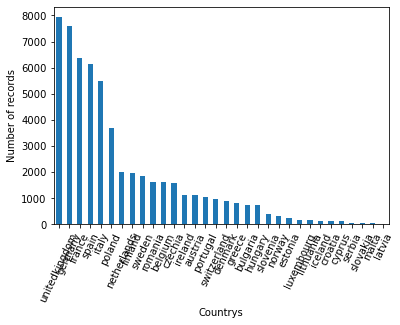

In [19]:
paises= dfs["countryname"].value_counts()
ax = paises.plot(kind='bar', xlabel='Countrys', ylabel='Number of records', rot=65)#.legend(title='Type of Pollution', bbox_to_anchor=(1, 1))

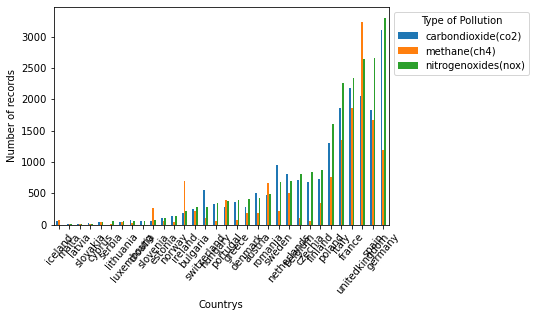

In [20]:
dfu=dfs.groupby(["countryname"])["pollutant"].value_counts().unstack().sort_values("nitrogenoxides(nox)")
ax = dfu.plot(kind='bar', xlabel='Countrys', ylabel='Number of records', rot=50).legend(title='Type of Pollution', bbox_to_anchor=(1, 1))

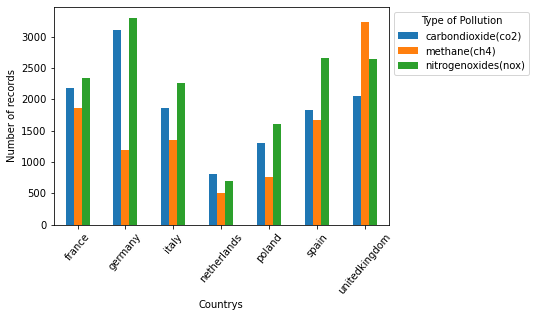

In [21]:
muestra=list(paises[paises>2000].index)
dfu=dfs[dfs["countryname"].isin(muestra)].groupby(["countryname"])["pollutant"].value_counts().unstack()#.sort_values("Nitrogen oxides (NOX)")
ax = dfu.plot(kind='bar', xlabel='Countrys', ylabel='Number of records', rot=50).legend(title='Type of Pollution', bbox_to_anchor=(1, 1))

### Countries and types of industries

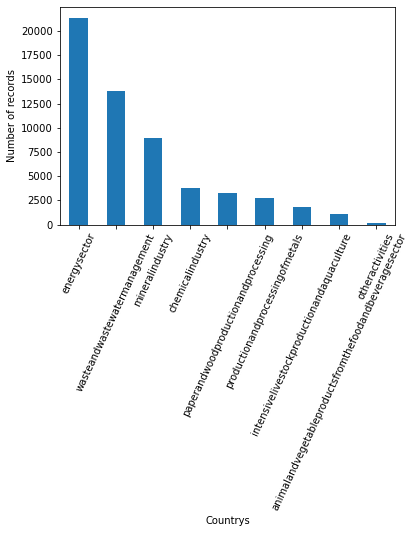

In [22]:
indus= dfs["eprtrsectorname"].value_counts()
ax = indus.plot(kind='bar', xlabel='Countrys', ylabel='Number of records', rot=65)

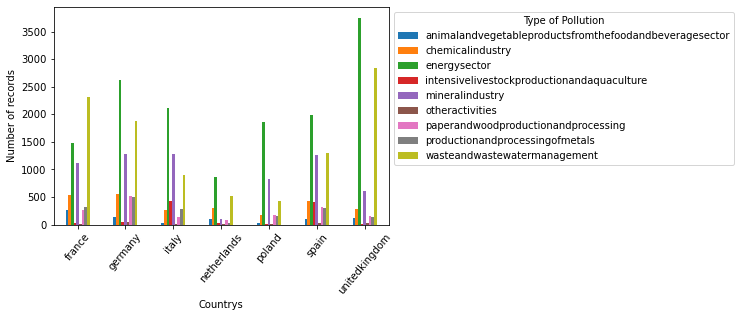

In [23]:
dfu=dfs[dfs["countryname"].isin(muestra)].groupby(["countryname"])["eprtrsectorname"].value_counts().unstack()#.sort_values("Nitrogen oxides (NOX)")
ax = dfu.plot(kind='bar', xlabel='Countrys', ylabel='Number of records', rot=50).legend(title='Type of Pollution', bbox_to_anchor=(1, 1))

## Industries and types of pollution

#### This is the only category that seems to matter. As you can see there is a really big distinction between the industries that emit methane and the ones that emit carbon dioxide and nitrogen oxides.

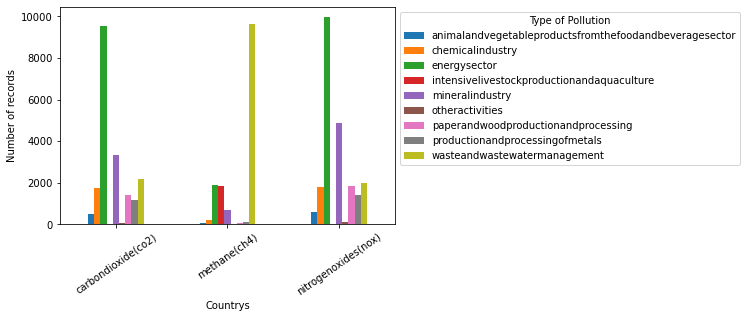

In [24]:
dfu=dfs.groupby(["pollutant"])["eprtrsectorname"].value_counts().unstack()#.sort_values("Nitrogen oxides (NOX)")
ax = dfu.plot(kind='bar', xlabel='Countrys', ylabel='Number of records', rot=35).legend(title='Type of Pollution', bbox_to_anchor=(1, 1))

### Type of subindustries

#### Subindustries are also relevant for the model.

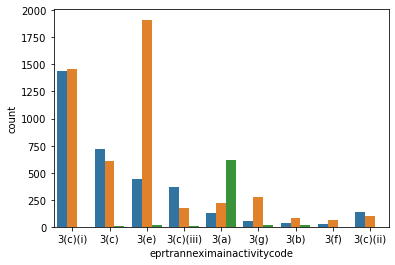

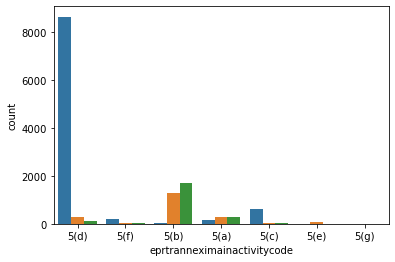

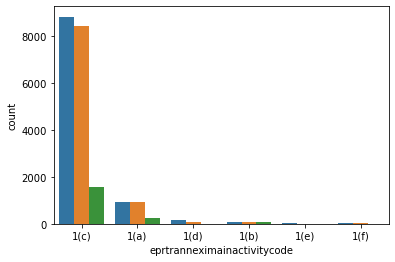

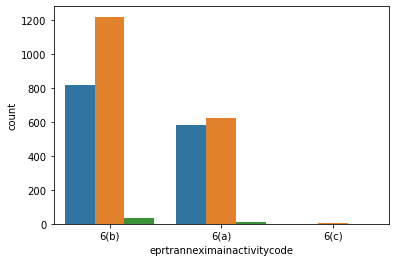

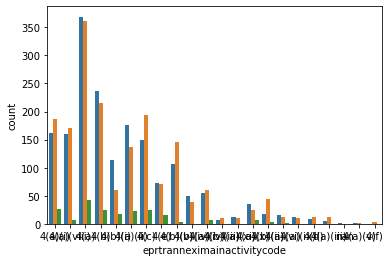

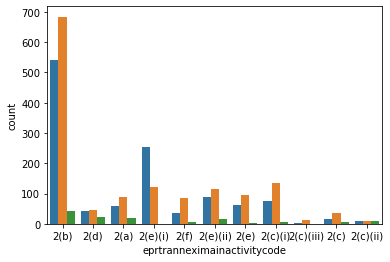

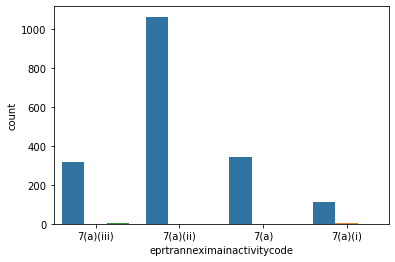

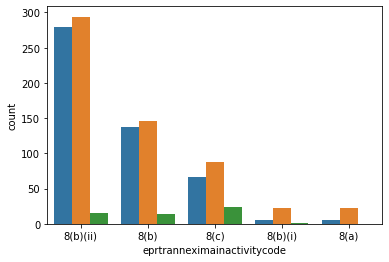

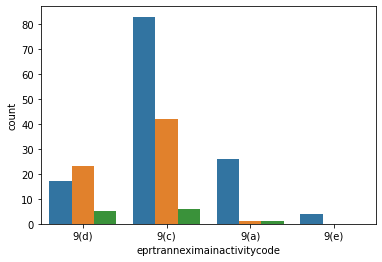

In [25]:
for i in dfs["eprtrsectorcode"].unique():
    plt.figure()
    sns.countplot(data=dfs[dfs["eprtrsectorcode"]==i], x='eprtranneximainactivitycode', hue='pollutant')
    plt.legend([],[], frameon=False)

In [26]:
dictlabel["3(a)"]

'Thermalpowerstationsandothercombustioninstallations'

## Stationarity

#### We thought that stationarity could be relevant for the type of pollution because some pollutants audits could be done at the beginning of the months and others at the end of the month but finally we realised it was not relevant either.

In [27]:
dfs = dfs.rename(columns={"reportingyear":"year"})
dfs["fecha"] = pd.to_datetime(dfs[['year', 'month', 'day']])
dfecha = dfs[["fecha","pollutant"]]
dfecha["newdate"] =  dfecha["fecha"]-dfecha["fecha"].min().to_pydatetime()
dfecha["newdate"] = dfecha["newdate"].apply(lambda x: x.days)

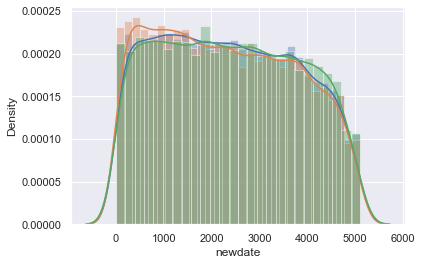

In [28]:
for i in dfecha["pollutant"].unique():
    sns.set()
    ax = sns.distplot(dfecha[dfecha["pollutant"]==i]["newdate"])

In [29]:
dfecha

,fecha,pollutant,newdate
0,2015-10-20,carbondioxide(co2),3214
1,2018-09-21,nitrogenoxides(nox),4281
2,2019-02-04,methane(ch4),4417
3,2012-08-06,nitrogenoxides(nox),2044
4,2018-12-22,methane(ch4),4373
...,...,...,...
0,2019-10-11,nitrogenoxides(nox),4666
0,2019-05-19,carbondioxide(co2),4521
0,2019-04-16,methane(ch4),4488
0,2019-02-03,nitrogenoxides(nox),4416


## Climate conditions

#### Climate conditions don't affect the type of pollutant either, as we suspected. However in the graphs we clearly see how the type of pollutant doesn't mind the weather conditions.

### Wind

In [30]:
dfs=pd.read_csv("sin_pfs.csv",delimiter=";")
dfs.drop_duplicates(inplace=True)

In [31]:
dfs[['max_wind_speed', 'avg_wind_speed', 'min_wind_speed']].sort_values('avg_wind_speed')
#bins = np.linspace(min(pd.to_numeric(df_num["wc"])), max(pd.to_numeric(df_num["wc"])), [])
bins=[min(dfs['avg_wind_speed']),17.000,19.000,max(dfs['avg_wind_speed'])]
categorias = ['Bajos', 'Normal', 'Alto']
dfs['avg_wind_speed_binned'] =  pd.cut(dfs['avg_wind_speed'], bins, labels=categorias, include_lowest=True )
dfs['avg_wind_speed_binned'].value_counts()

Alto      21483
Bajos     21246
Normal    14331
Name: avg_wind_speed_binned, dtype: int64

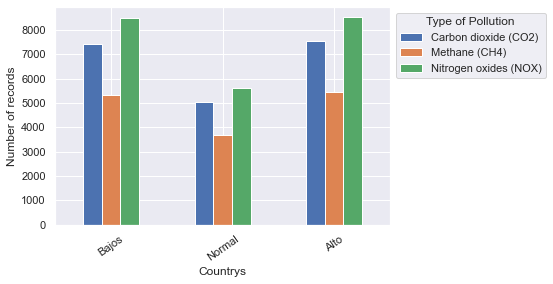

In [32]:
dfu=dfs.groupby(['avg_wind_speed_binned'])["pollutant"].value_counts().unstack()#.sort_values("Nitrogen oxides (NOX)")
ax = dfu.plot(kind='bar', xlabel='Countrys', ylabel='Number of records', rot=35).legend(title='Type of Pollution', bbox_to_anchor=(1, 1))

### Temperature

In [33]:
dfs[['max_temp', 'avg_temp', 'min_temp']].sort_values('avg_temp')

,max_temp,avg_temp,min_temp
4376,-3.141464,-0.199176,1.515467
41032,-1.587919,-0.198657,3.161736
64980,-0.075955,-0.198574,2.326121
47917,-1.331984,-0.197947,4.418910
5288,-0.615211,-0.195632,3.913325
...,...,...,...
54980,20.173701,19.998588,22.742328
56984,19.219961,19.998645,23.156135
16394,17.490289,19.998710,24.325419
26136,17.471201,19.999343,23.749223


In [34]:
bins = np.linspace(min(dfs['avg_temp']), max(dfs['avg_temp']), 6)
#bins=[min(df['avg_temp']),5,9,14,max(df['avg_temp'])]
categorias = ['UltraBajos', 'Bajos', 'Medio', 'Alto', 'Altísimo']
dfs['avg_temp_speed_binned'] =  pd.cut(dfs['avg_temp'], bins, labels=categorias, include_lowest=True )
dfs['avg_temp_speed_binned'].value_counts()

Medio         16391
Alto          14876
Bajos          9531
Altísimo       8721
UltraBajos     7541
Name: avg_temp_speed_binned, dtype: int64

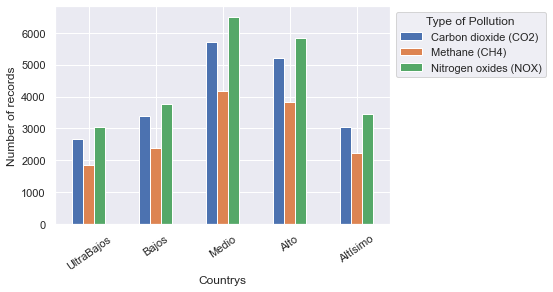

In [35]:
dfu=dfs.groupby(['avg_temp_speed_binned'])["pollutant"].value_counts().unstack()#.sort_values("Nitrogen oxides (NOX)")
ax = dfu.plot(kind='bar', xlabel='Countrys', ylabel='Number of records', rot=35).legend(title='Type of Pollution', bbox_to_anchor=(1, 1))

### Notebook by:
### Adrián Cox Garzón
### David Moscoso
### JC Pardo Medina (Juan Carlos)
